# Project Part F: All Together Now

![](banner_project.jpg)

In [1]:
analyst = "Lan Dinh" # Replace this with your name

In [2]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
options(repr.matrix.max.rows=674)
update_geom_defaults("point", list(size=1))
update_geom_defaults("col", list(fill=PALETTE[1]))
out(5.8,2.1)

## Introduction

### Decision

Recommend a portfolio of 12 company investments that will maximize 12-month profit on a \$1,000,000 investment.

### Approach

Retrieve a public company fundamentals dataset comprising thousands of US companies from quarters 1, 2, 3, and 4 of year 2017 + company stock price data for those companies from quarter 4 of year 2018.

Prepare the data so that each company and its associated information is represented as a single observation.

Apply various descriptive statistics and data visualizations to look for interesting patterns and inter-company relationships.

Transform the dataset using variable filtration, imputation, principal component analysis, and other methods to ready it for predictive model construction.

Build models to predict whether stock price will grow more than 30% over 12 months, given 12 months of past company fundamentals data, using machine learning model construction methods.  Evaluate and tune the models for best business performance.

Build models to predict how much stock price will grow over 12 months, given 12 months of past company fundamentals data, using machine learning model construction methods.  Evaluate and tune the models for best business performance.

Identify the best performing model.

Retrieve an investment opportunities dataset, comprising fundamentals for some set of public companies over some one-year period. Transform the representation of the investment opportunities to match the representation expected by the best performing model, leveraging previous analysis.

Use the best performing model to make predictions about the investment opportunities and accordingly recommend a portfolio of 12 company investments.

### Data Source

Data files:

* Data Dictionary.csv
* Company Fundamentals 2017.csv
* Company Fundamentals 2018.csv

The datasets and accompanying data dictionary are sourced from ...

* Wharton Research Data Services > Compustat - Capital IQ from Standard & Poor's > North America - Daily > Fundamentals Quarterly (https://wrds-www.wharton.upenn.edu/)

  * Date Variable: Data Date
  * Date Range: 2017-01 to 2017-12 -or- 2018-01 to 2018-12
  * Company Codes: Search the entire database
    * Consolidtaion Level: C, Output
    * Industry Format: INDL, FS, Output
    * Data Format: STD, Output
    * Population Source: D, Output
    * Quarter Type: Fiscal View, Output
    * Currency: USD, Output (not CAD)
    * Company Status: Active, Output (not Inactive)
  * Variable Types: Data Items, Select All (674)
  * Query output:
    * Output format: comma-delimited text
    * Compression type: None
    * Data format: MMDDYY10

The datasets are restricted to select US active, publicly held companies that reported quarterly measures including stock prices for 1st, 2nd, 3rd, and 4th quarters in years 2017 and 2018.  All non-missing stock prices exceed $3 per share.  File formats are all comma-separated values (CSV).

The data dictionary is from Variable Descriptions tab, copied to Excel, saved in csv format.

_**For this project, do not source any additional data from year 2019.**_

## Business Model & Business Parameters

The business model is ...

<p style="text-indent: 15px;">
$\begin{align}
& \textsf{profit} = \left( \sum_{i \in \textsf{portfolio}} (1 + \textsf{growth}_i) \times \textsf{allocation}_i \right) - \textsf{budget} \\ \\
& \textsf{profit rate} = \textsf{profit} \div \textsf{budget} \\ \\
& \textsf{budget} = \sum_{i \in \textsf{portfolio}} \textsf{allocation}_i \\ \\
\end{align}$


Business parameters include ...

* $\textsf{budget}$ is total investment to allocate across the companies in the portfolio<br>
* $\textsf{portfolio size}$ is number of companies in the portfolio<br>
* $\textsf{allocation}$ is vector of amounts to allocate to specific companies in the portfolio, must sum to budget
* $\textsf{threshold}$ is growth that qualifies as lowest attractive growth

In [14]:
# Set the business parameters.

budget = 1000000
portfolio_size = 12
# allocation = rep(1000000/12, 12) # you can keep or change this setting
threshold = 0.30 # you can keep or change this setting

x = 1000000 / (12+11+10+9+8+7+6+5+4+3+2+1)
allocation = c(12*x, 11*x, 10*x, 9*x, 8*x, 7*x, 6*x, 5*x, 4*x, 3*x, 2*x, 1*x) # another of several possible allocations

fmtsx(fmt(budget), fmt(portfolio_size),fmt(allocation), fmt(threshold))

budget
"1,000,000"
portfolio_size
12
allocation
"153,846"
"141,026"
"128,205"
"115,385"
"102,564"
"89,744"


Portfolio to be filled with companies that will maximize profit.

## Data

### Retrieve Raw Data

In [4]:
# Retrieve the 2017 data.
# How many observations and variables?

data.2017 = read.csv("Company Fundamentals 2017.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.2017))

observations,variables
"33,269",680


In [5]:
# Retrieve the 2018 data.
# How many observations and variables?

data.2018 = read.csv("Company Fundamentals 2018.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.2018))

observations,variables
"35,728",680


### Prepare

_2017 Data:_

Partition the dataset by calendar quarter in which information is reported. Filter in observations to include only those with non-missing `prccq` $\geq$ 3.  Then remove any observations about companies that reported more than once per quarter.  Then change all the variable names (except for the `gvkey`, `tic`, and `conm` variables) by suffixing them with quarter information - e.g., in the Quarter 1 dataset, `prccq` becomes `prccq.q1`, etc.  Consolidate the four quarter datasets into one dataset, with one observation per company that includes variables for all four quarters.  Remove any observations with missing `prccq.q4` values.

_2018 Data:_

Filter the dataset by calendar quarter in which information is reported, keeping only observations with information reported in quarter 4. Additionally, filter in observations to include only those with non-missing `prccq`, and keep only the `gvkey` and `prccq` variables.  Then remove any observations about companies that reported more than once per quarter.

_2017/2018 Data:_

Consolidate the processed 2017 dataset and processed 2018 dataset, keeping only observations that have both 2017 and 2018 information.  Then add these 2 synthetic variables:

<p style="text-indent: 15px;">
$\begin{align}
\textsf{growth} & = \left( \textsf{prccq} - \textsf{prccq.q4} \right) \div \textsf{prccq.q4} \\
\textsf{big growth} & = \textsf{growth} \geq \textsf{threshold}
\end{align}$

In [6]:
# Partition the 2017 data.
# Consolidate the 2017 data partitions.
# Filter the 2018 data.
# Consolidate the 2017 data and 2018 data.
# How many observations and variables?

# 2017
q = quarter(mdy(data.2017$datadate))

data.current.q1 = data.2017[(q==1) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]
data.current.q2 = data.2017[(q==2) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]
data.current.q3 = data.2017[(q==3) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]
data.current.q4 = data.2017[(q==4) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]

data.current.q1 = data.current.q1[!duplicated(data.current.q1$gvkey),]
data.current.q2 = data.current.q2[!duplicated(data.current.q2$gvkey),]
data.current.q3 = data.current.q3[!duplicated(data.current.q3$gvkey),]
data.current.q4 = data.current.q4[!duplicated(data.current.q4$gvkey),]

data.current.q1 = rename_with(data.current.q1, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q1")))
data.current.q2 = rename_with(data.current.q2, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q2")))
data.current.q3 = rename_with(data.current.q3, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q3")))
data.current.q4 = rename_with(data.current.q4, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q4")))

data.current = merge(data.current.q1, data.current.q2, by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q3, by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q4, by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current =data.current[!is.na(data.current$prccq.q4),]

# 2018
q = quarter(mdy(data.2018$datadate))

data.future.q4 = data.2018[(q==4) & !is.na(data.2018$prccq),c("gvkey", "prccq")]
data.future.q4 = data.future.q4[!duplicated(data.future.q4$gvkey),]

# 2017/2018
data = merge(data.current, data.future.q4, by="gvkey", all=FALSE)

data$growth = (data$prccq - data$prccq.q4) / data$prccq.q4
data$big_growth = factor(data$growth >= threshold, levels=c(TRUE, FALSE), labels=c("YES", "NO"))

data = relocate(data, big_growth, growth, prccq) 
fmtx(size(data))

observations,variables
"4,305","2,714"


## Exploratory Data Analysis

In [23]:
# Show fraction of observations that are missing price data.

fmtx(nrow(data[is.na(data$prccq.q1) | is.na(data$prccq.q2) | is.na(data$prccq.q3) | is.na(data$prccq.q4),])/nrow(data),"fraction of observations with missing price data", blank=TRUE)


""
0.0857


In [24]:
# Show another interesting descriptive statistic.
fmtsx(fmt(quantile(data$prccq.q1,na.rm=TRUE),row.names=TRUE,blank=TRUE,"quartiles of prccq.q1"),
      fmt(quantile(data$prccq.q2,na.rm=TRUE),row.names=TRUE,blank=TRUE,"quartiles of prccq.q2"),
      fmt(quantile(data$prccq.q3,na.rm=TRUE),row.names=TRUE,blank=TRUE,"quartiles of prccq.q3"),
      fmt(quantile(data$prccq.q4,na.rm=TRUE),row.names=TRUE,blank=TRUE,"quartiles of prccq.q4"),
      fmt(quantile(data$prccq,na.rm=TRUE),row.names=TRUE,blank=TRUE,"quartiles of prccq"))

quartiles of prccq.q1 
 
 
   
 
 
 
 
 0% 
 3.019 
 
 
 25% 
 12.655 
 
 
 50% 
 24.575 
 
 
 75% 
 49.477 
 
 
 100% 
 14,000.000 
 
 
 

 
 

 
 quartiles of prccq.q2 
 
 
   
 
 
 
 
 0% 
 3.00 
 
 
 25% 
 12.27 
 
 
 50% 
 24.26 
 
 
 75% 
 49.42 
 
 
 100% 
 14,000.00 
 
 
 

 
 

 
 quartiles of prccq.q3 
 
 
   
 
 
 
 
 0% 
 3.00 
 
 
 25% 
 12.46 
 
 
 50% 
 24.92 
 
 
 75% 
 50.47 
 
 
 100% 
 15,500.00 
 
 
 

 
 

 
 quartiles of prccq.q4 
 
 
   
 
 
 
 
 0% 
 3.00 
 
 
 25% 
 11.55 
 
 
 50% 
 24.69 
 
 
 75% 
 51.07 
 
 
 100% 
 14,000.00 
 
 
 

 
 

 
 quartiles of prccq 
 
 
   
 
 
 
 
 0% 
 0.025 
 
 
 25% 
 9.400 
 
 
 50% 
 20.980 
 
 
 75% 
 45.490 
 
 
 100% 
 14,450.000

In [25]:
# Show another interesting descriptive statistic.
freq.big_growth = rename(as.data.frame(table(data$big_growth)), value=Var1, count=Freq)
rfreq.big_growth = rename(as.data.frame(table(data$big_growth) / length(data$big_growth)), value=Var1, probability=Freq)
fmtsx(fmt(freq.big_growth), fmt(rfreq.big_growth))

value,count
YES,360
NO,"3,945"
value,probability
YES,0.0836
NO,0.9164


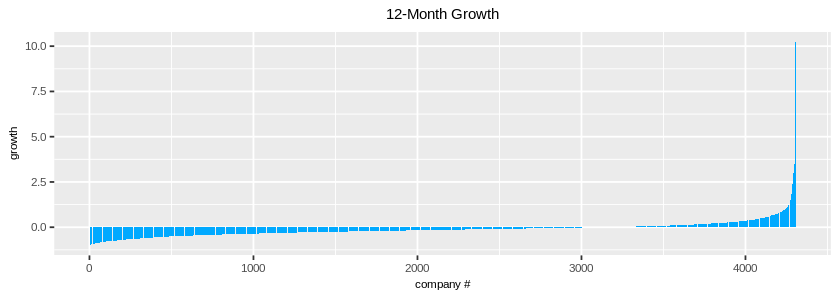

In [29]:
# Visualize growth across companies.
ggplot(data)+ 
ggtitle("12-Month Growth")+
xlab("company #")+
geom_col(aes(x=rank(growth, ties.method="first"), y=growth))


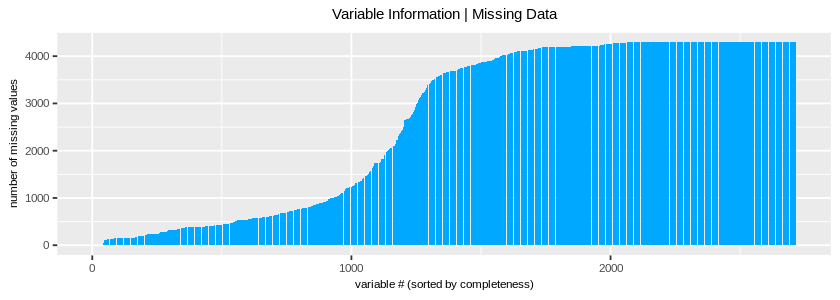

In [28]:
# Visualize the amount of missing data across variables.
miss.data = data.frame(na_count=as.numeric(summarize_all(data, ~sum(is.na(.)))))
ggplot(miss.data)+
ggtitle("Variable Information | Missing Data") +
xlab("variable # (sorted by completeness)")+
ylab("number of missing values")+
geom_col(aes(x=rank(na_count, ties.method="first"), y=na_count))


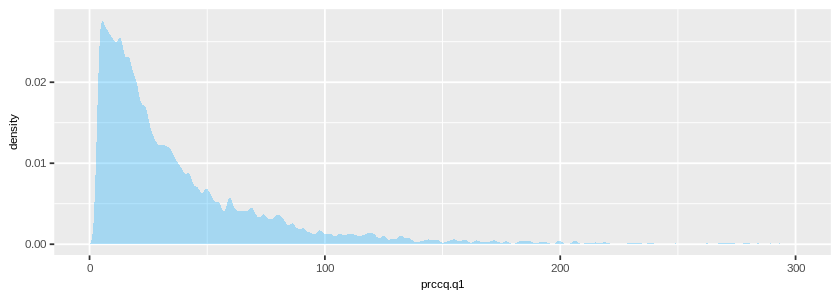

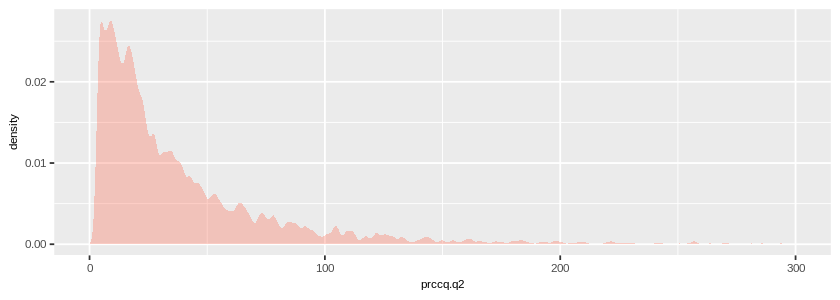

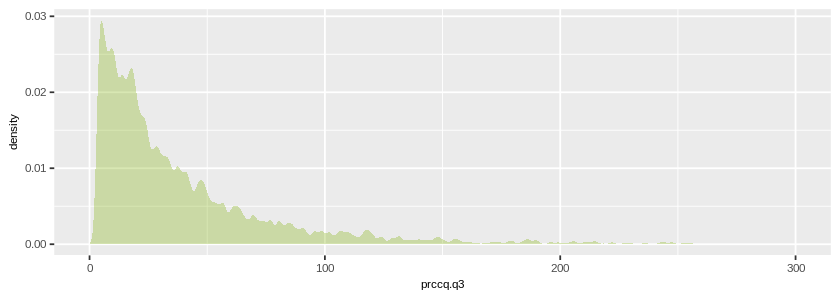

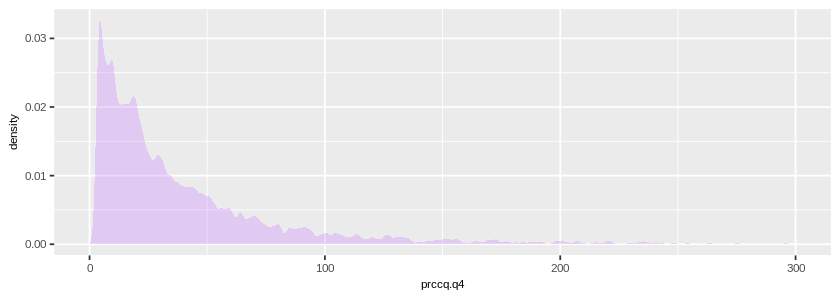

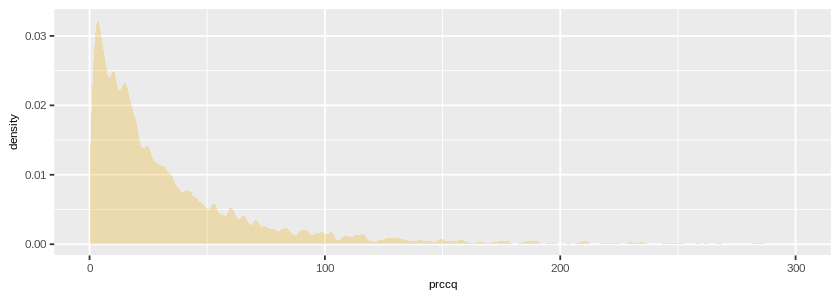

In [27]:
# Show another interesting visualization.
out(7,2.5)
ggplot(data)+
xlim(0,300)+
geom_density(aes(prccq.q1), kernel="gaussian",bw=1, alpha=0.3, fill=PALETTE[1])

ggplot(data)+
xlim(0,300)+
geom_density(aes(prccq.q2), kernel="gaussian",bw=1, alpha=0.3, fill=PALETTE[2])

ggplot(data)+
xlim(0,300)+
geom_density(aes(prccq.q3), kernel="gaussian",bw=1, alpha=0.3, fill=PALETTE[3])

ggplot(data)+
xlim(0,300)+
geom_density(aes(prccq.q4), kernel="gaussian",bw=1, alpha=0.3, fill=PALETTE[4])

ggplot(data)+
xlim(0,300)+
geom_density(aes(prccq), kernel="gaussian",bw=1, alpha=0.3, fill=PALETTE[5])

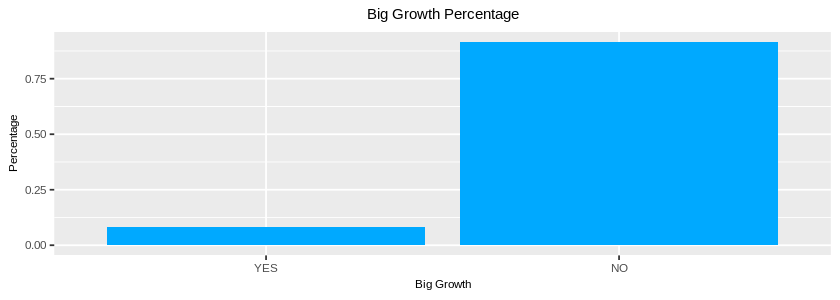

In [15]:
# Show another interesting visualization.
ggplot(rfreq.big_growth) + 
ggtitle("Big Growth Percentage") + 
xlab("Big Growth")+
ylab("Percentage")+
geom_col(aes(x=value, y=probability)) + 
theme.no_legend

## Data Transformation

Transform data representation:

* Filter the data to include only predictor variables with at least 95% non-missing values.
* Impute missing data ...
  * for each numerical variable, use the mean of non-missing values
  * for each non-numerical variable, use the mode of non-missing values
* Filter the data to include only numerical variables with non-zero variance.
* Transform normalized numerical predictor variables to principal component representation.
* Restore the outcome and identifier variables.
* Filter in outcome and identifier variables, and first three principal components.

In [7]:
# Specify outcome, identifier, and predictor variables.
prevars=colnames(data[,4:ncol(data)])
outvars=c("big_growth","growth","prccq")
idvars=c("gvkey","tic","conm")

# Filter out sparse variables.
data.filter= select_if(data[,prevars], ~mean(is.na(.))<0.05)

# Impute missing data.
data.imputed = as.data.frame(impute(data.filter))

# Transform numerical predictor variables to principal component representation
data.selected = select_if(data.imputed, ~is.numeric(.))
data.selected = select_if(data.selected, ~var(., na.rm=TRUE) !=0)
pc = prcomp(data.selected, scale=TRUE)
centrol = as.data.frame(pc$center)
weight_matrix = as.data.frame(pc$rotation)
data.pc = as.data.frame(pc$x)

# Restore the outcome and indentifier variables to the data.
data.pcv = cbind(data[,c(outvars,idvars)],data.pc)

# Filter in outcome and identifier variables, and first three principal components.
data = data.pcv[,c(outvars,idvars, "PC1","PC2","PC3")]

# How many observations and variables?
fmtx(size(data))

# Show first few observations of transformed data.
fmtx(data[1:6,],"data (first few observation)")

observations,variables
"4,305",9


big_growth,growth,prccq,gvkey,tic,conm,PC1,PC2,PC3
NO,0.0507,43.69,"1,004",AIR,AAR CORP,1.4098,0.2125,-0.1874
NO,-0.3829,32.11,"1,045",AAL,AMERICAN AIRLINES GROUP INC,-2.8093,0.2246,1.4366
YES,0.3158,6.75,"1,050",CECE,CECO ENVIRONMENTAL CORP,1.5247,0.4396,-0.1679
NO,-0.2165,8.66,"1,062",ASA,ASA GOLD AND PRECIOUS METALS,1.5737,0.6384,0.0123
NO,-0.1185,15.25,"1,072",AVX,AVX CORP,1.2813,0.4529,0.0929
NO,0.0002,85.20,"1,075",PNW,PINNACLE WEST CAPITAL CORP,0.3698,-0.4861,-0.0128


## Model 1

Model 1 is a naive Bayes classifier that predicts whether or not a company stock price will grow by 30% or more at 12 months.

In [8]:
# Build, evaluate, and tune a naive Bayes model by iterating through PC1, PC2, PC3 
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 

set.seed(0)
fold = createFolds(data$big_growth, k=5)
tune = data.frame()

for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth"))
{   nfold = 5
    set.seed(0)
    profit = c()
    for (i in 1:nfold){
        data.test = data[fold[[i]],]
        data.train = data[setdiff(1:nrow(data), fold[[i]]),]
        model_train = naiveBayes(big_growth~., data.train[,f])
        prob = predict(model_train, data.test, type="raw")
        class.predicted = as.class(prob, class="YES", cutoff=0.5)
        
        data.new = cbind(data.test, prob)
        data.new = data.new[order(-data.new$YES),]
        profit[i] = sum((1+data.new[1:12,]$growth)*allocation) - budget
    }
    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="naive bayes", variables=vector2string(f),profit.cv))
}
best = tune[which.max(tune$profit.cv),]

fmtsx(fmt(data.frame(allocation), NA),
      fmt(tune,"search for best model"),
      fmt(best, "best model"))


allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 2

Model 2 is a linear regression regressor that predicts company growth at 12 months.

In [39]:
# Build, evaluate, and tune a linear regression model by iterating through PC1, PC2, PC3
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 
tune = data.frame()

for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="growth"))
{   nfold = 5
    set.seed(0)
    fold = createFolds(data$growth, k=nfold)
    profit = c()
    for (i in 1:nfold){
        data.test = data[fold[[i]],]
        data.train = data[setdiff(1:nrow(data), fold[[i]]),]
        model_train = lm(growth~., data.train[,f])
        outcome.predicted = predict(model_train, data.test)
        
        data.new = cbind(data.test, outcome.predicted)
        data.new = data.new[order(-data.new$outcome.predicted),]
        profit[i] = sum((1+data.new[1:12,]$growth)*allocation) - budget
    }
    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="linreg", variables=vector2string(f),profit.cv))
}
best = tune[which.max(tune$profit.cv),]

fmtsx(fmt(data.frame(allocation), NA),
      fmt(tune,"search for best model"),
      fmt(best, "best model"))



allocation
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"
"83,333"


## Model 3

Model 3 is a logistic regression classifier that predicts whether or not a company stock price will grow by 30% or more at 12 months. Second option of allocation is used.

In [22]:
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and
# estimated profit for the searched and best performing models. 

tune = data.frame()

for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth"))
{   nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
    for (i in 1:nfold){
        data.test = data[fold[[i]],]
        data.train = data[setdiff(1:nrow(data), fold[[i]]),]
        model_train = glm(big_growth ~., binomial(link="logit"), data.train[,f])
        prob.Y = predict(model_train, data.test, type="response")
        prob = data.frame("YES"=prob.Y, "NO"=1-prob.Y)
        class.predicted = as.class(prob, class="YES", cutoff=0.7)
        
        data.new = cbind(data.test, prob)
        data.new = data.new[order(-data.new$YES),]
        profit[i] = sum((1+data.new[1:12,]$growth)*allocation) - budget
    }
    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="logreg", variables=vector2string(f),profit.cv))
}
best = tune[which.max(tune$profit.cv),]

fmtsx(fmt(data.frame(allocation), NA),
      fmt(tune,"search for best model"),
      fmt(best, "best model"))



allocation
"153,846"
"141,026"
"128,205"
"115,385"
"102,564"
"89,744"
"76,923"
"64,103"
"51,282"
"38,462"


## Model 4

Model 4 is a decision tree classifier that predicts whether or not a company stock price will grow by 30% or more at 12 months. Second option of allocation is used.

In [28]:
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and estimated profit
# for the searched and best performing models. 
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and
# estimated profit for the searched and best performing models. 

tune = data.frame()

for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth"))
{   nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
    for (i in 1:nfold){
        data.test = data[fold[[i]],]
        data.train = data[setdiff(1:nrow(data), fold[[i]]),]
#         set.seed(0)
        model_train = rpart(big_growth ~., data.train[,f], method="class", minsplit=2, cp=0, maxdepth=30)
        prob = predict(model_train, data.test, type="prob")
        class.predicted = as.class(prob, class="YES", cutoff=0.5)
        
        
        data.new = cbind(data.test, prob)
        data.new = data.new[order(-data.new$YES),]
        profit[i] = sum((1+data.new[1:12,]$growth)*allocation) - budget
    }
    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="decision tree", variables=vector2string(f),profit.cv))
}
best = tune[which.max(tune$profit.cv),]

fmtsx(fmt(data.frame(allocation), NA),
      fmt(tune,"search for best model"),
      fmt(best, "best model"))




allocation
"153,846"
"141,026"
"128,205"
"115,385"
"102,564"
"89,744"
"76,923"
"64,103"
"51,282"
"38,462"


## Model 5

Model 2 is a k-Nearest Neighbors regressor that predicts company growth at 12 months. Second option of allocation is used.

In [15]:
tune = data.frame()

for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="growth"))
{   nfold = 5
    set.seed(0)
    fold = createFolds(data$growth, k=nfold)
    profit = c()
    for (i in 1:nfold){
        data.test = data[fold[[i]],]
        data.train = data[setdiff(1:nrow(data), fold[[i]]),]
        outcome.predicted = kknn(growth~., data.train[,f], data.test, k=3)$fitted.values
        
        data.new = cbind(data.test, outcome.predicted)
        data.new = data.new[order(-data.new$outcome.predicted),]
        profit[i] = sum((1+data.new[1:12,]$growth)*allocation) - budget
    }
    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="knn (regression form)", variables=vector2string(f),profit.cv))
}
best = tune[which.max(tune$profit.cv),]

fmtsx(fmt(data.frame(allocation), NA),
      fmt(tune,"search for best model"),
      fmt(best, "best model"))


allocation
"153,846"
"141,026"
"128,205"
"115,385"
"102,564"
"89,744"
"76,923"
"64,103"
"51,282"
"38,462"


## Model 6

Model 6 is a k-Nearest Neighbors classifier that predicts whether or not a company stock price will grow by 30% or more at 12 months. Second option of allocation is used.

In [16]:
# Build, evaluate, and tune a model.
# Show the allocations assumed, predictor variable/hyperparameter combination and estimated profit
# for the searched and best performing models. 
tune = data.frame()

for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth"))
{   nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
    for (i in 1:nfold){
        data.test = data[fold[[i]],]
        data.train = data[setdiff(1:nrow(data), fold[[i]]),]
        prob = kknn(big_growth ~., data.train[,f], data.test, k=3)$prob
        class.predicted = as.class(prob, class="YES", cutoff=0.6)
        
        
        data.new = cbind(data.test, prob)
        data.new = data.new[order(-data.new$YES),]
        profit[i] = sum((1+data.new[1:12,]$growth)*allocation) - budget
    }
    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="knn", variables=vector2string(f),profit.cv))
}
best = tune[which.max(tune$profit.cv),]

fmtsx(fmt(data.frame(allocation), NA),
      fmt(tune,"search for best model"),
      fmt(best, "best model"))


allocation
"153,846"
"141,026"
"128,205"
"115,385"
"102,564"
"89,744"
"76,923"
"64,103"
"51,282"
"38,462"


## Investment Opportunities

Test the best performing model on new investment opportunities.

### Retrieve Investment Data

In [18]:
# Retrieve the investment opportunities data.
# How many observations and variables?

data.io = read.csv("Investment Opportunities.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.io))

observations,variables
918,680


### Prepare Investment Data

In [19]:
# Prepare the investment opportunities data as appropriate for transformation.
# How many observations and variables?

q = quarter(mdy(data.io$datadate))

data.current.q1 = data.io[(q==1) & !is.na(data.io$prccq),]
data.current.q2 = data.io[(q==2) & !is.na(data.io$prccq),]
data.current.q3 = data.io[(q==3) & !is.na(data.io$prccq),]
data.current.q4 = data.io[(q==4) & !is.na(data.io$prccq),]

data.current.q1 = data.current.q1[!duplicated(data.current.q1$gvkey),]
data.current.q2 = data.current.q2[!duplicated(data.current.q2$gvkey),]
data.current.q3 = data.current.q3[!duplicated(data.current.q3$gvkey),]
data.current.q4 = data.current.q4[!duplicated(data.current.q4$gvkey),]

data.current.q1 = rename_with(data.current.q1, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q1")))
data.current.q2 = rename_with(data.current.q2, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q2")))
data.current.q3 = rename_with(data.current.q3, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q3")))
data.current.q4 = rename_with(data.current.q4, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q4")))

data.current = merge(data.current.q1, data.current.q2, by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q3, by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q4, by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current =data.current[!is.na(data.current$prccq.q4),]
fmtx(size(data.current))

observations,variables
230,"2,711"


### Transform Investment Data

In [20]:
# Transform the prepared investment dataset as apprpriate for use with the
# best performing model.
# How many observations and variables?
# Show the first few observations of the resulting dataset.

cn = readRDS("My Filter.rds")

data.ps = data.current[, cn]

ml = readRDS("My Imputation.rds")
data.imputed = put_impute(data.ps, ml)

pc = readRDS("My PC.rds")
data.pc = predict(pc, data.imputed)


prevars = readRDS("My Predictors.rds")
data.pcv = cbind(data.imputed,data.pc)
data.real = data.pcv[,prevars]

fmtx(size(data.real))
fmtx(data.real[1:6,],"")

observations,variables
230,6


gvkey,tic,conm,PC1,PC2,PC3
"1,004",AIR,AAR CORP,1.4196,0.0580,-0.2577
"1,410",ABM,ABM INDUSTRIES INC,1.0563,0.0729,-0.1602
"1,562",AMSWA,AMERICAN SOFTWARE -CL A,1.6304,0.3224,-0.1279
"1,618",AXR,AMREP CORP,0.8877,0.1452,-0.6410
"1,632",ADI,ANALOG DEVICES,-1.6234,-0.4854,-0.9771
"1,686",APOG,APOGEE ENTERPRISES INC,1.4219,-0.1529,-0.3698


## Apply Model

### Build Best Model

In [23]:
# Build the best performing model using all 2017 and 2018 data for training.
model = data
outcome.predicted = kknn(growth~PC1+PC2+PC3, data, data.real, k=3)$fitted.values

portfolio = data.real[order(-outcome.predicted),]



### Recommend Portfolio

In [24]:
# Use the model to inform the decision about how to fill the portfolio with companies
# from the investment opportunities.
# Show the portfolio: gvkey, tic, conm, allocation

portfolio = portfolio[1:12,1:3]
portfolio$allocation = allocation
fmtx(portfolio)

gvkey,tic,conm,allocation
"1,562",AMSWA,AMERICAN SOFTWARE -CL A,"153,846"
"188,856",FRG,FRANCHISE GROUP INC,"141,026"
"26,677",SCWX,SECUREWORKS CORP,"128,205"
"63,172",FDS,FACTSET RESEARCH SYSTEMS INC,"115,385"
"24,508",OOMA,OOMA INC,"102,564"
"65,430",PLCE,CHILDRENS PLACE INC,"89,744"
"162,988",ZUMZ,ZUMIEZ INC,"76,923"
"2,829",RFIL,R F INDUSTRIES LTD,"64,103"
"33,718",BJ,BJS WHSL CLUB HLDGS INC,"51,282"
"4,418",ENZ,ENZO BIOCHEM INC,"38,462"


### Store Portfolio Recommendation

In [25]:
write.csv(portfolio, paste0(analyst, "-final.csv"), row.names=FALSE)

### Confirm That Format Is Correct

In [26]:
portfolio.retrieved = read.csv(paste0(analyst, "-final.csv"), header=TRUE)
opportunities = unique(read.csv("Investment Opportunities.csv", header=TRUE)$gvkey)

columns = all(colnames(portfolio.retrieved) == c("gvkey", "tic", "conm", "allocation"))
companies = all(portfolio.retrieved$gvkey %in% opportunities)
allocations = round(sum(portfolio.retrieved$allocation)) == budget
                         
check = data.frame(analyst, columns, companies, allocations)
fmtx(check, "Portfolio Recommendation | Format Check")

analyst,columns,companies,allocations
Lan Dinh,TRUE,TRUE,TRUE


## Discussion

In my approach to choosing the best model for recommending 12 companies with the highest stock prices based on data from 2017 and 2018, I conducted an analysis using six different models: Naive Bayes, Linear Regression, Decision Tree, Logistic Regression, kNN Regressor, and kNN Classifier. The goal was to identify the model that would generate the highest profit. 

To ensure a robust evaluation, I employed cross-validation, which involves partitioning the data into training and validation sets, allowing me to assess the model's performance on unseen data. By using cross-validation, I aimed to select the best model with the best hyperparameters.

I experimented with both classifier and regressor models to evaluate their suitability for the task. After evaluating the models and their corresponding allocation options, I found that the kNN Regressor model performed the best, generating a profit of $745,801 with the second allocation option. This outcome provided valuable insights into the potential profitability of the selected companies based on their stock prices.

Throughout the process, I also conducted sensitivity analyses to assess the impact of different allocation options on the profitability of the models. This analysis allowed me to identify the sensitivity of the models to allocation decisions and understand how they might perform under different circumstances.

From this project, I learned the importance of trying different models and performing sensitivity analyses with various allocation options to determine the best approach for generating the highest profit. It highlighted the significance of model selection and parameter tuning in achieving accurate and profitable predictions.

In future work, I can build upon this experience by exploring different parameters of the models. By experimenting with a wider range of hyperparameters, I can conduct more comprehensive comparisons to identify the optimal configuration for each model. This approach will provide further insights into the model's performance and potentially lead to improved profitability.

Additionally, I can extend my analysis by incorporating more recent data beyond 2018. This would help ensure the models are trained on the most up-to-date information, allowing for more accurate predictions and potentially higher profits.

Overall, my approach involved trying different models, conducting sensitivity analyses with different allocation options, and leveraging cross-validation to select the best model. This project has provided valuable lessons that will guide me in future work, enabling me to refine my models, explore different parameters, and enhance profitability predictions in stock market recommendations.


<p style="text-align:left; font-size:10px;">
Copyright (c) Huntsinger Associates, LLC
<span style="float:right;">
Document revised May 6, 2023
</span>
</p>